In [147]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from prep_data import prep_data
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [3]:
train_loader, test_loader = prep_data()

(2, 5)


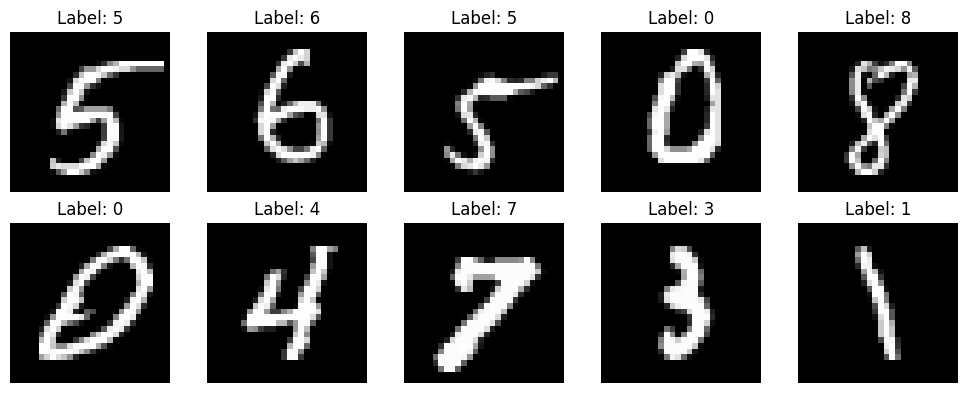

In [4]:
# Function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axs = axes.flatten()
    print(axes.shape)
    for i in range(10):
        axs[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axs[i].set_title(f"Label: {labels[i]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, lbls = next(dataiter)

# Show images
show_images(images[:10], lbls[:10])

In [5]:
class ShallowNN(nn.Module):
    def __init__(self, latent_size=128):
        super().__init__()
        self.dim_reduction = nn.Linear(28*28, latent_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = self.dim_reduction(x)
        x = self.relu(x)
        return self.output(x)

class MultiLayerNN(nn.Module):
    def __init__(self, latent_size=128, num_layers=3):
        super().__init__()
        self.dim_reduction = nn.Linear(28*28, latent_size)
        layers = []
        for i in range(num_layers):
            layers.extend([nn.Linear(latent_size, latent_size), nn.ReLU()])
        self.hidden_layers = nn.ModuleList(
            layers,
        )
        self.output = nn.Linear(latent_size, 10)

    def forward(self, x):
        x = self.dim_reduction(x)
        x = nn.ReLU()(x)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output(x)

In [6]:
model = torch.compile(MultiLayerNN(latent_size=128, num_layers=3), mode="max-autotune").to(device)

In [7]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=30)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
for epoch in range(30):
    for data, labels in train_loader:
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device)
        preds = model(data)
        loss = criterion(preds, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
    scheduler.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

W0912 11:10:39.867000 90973 site-packages/torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 1 | Loss: 0.2656
Epoch 2 | Loss: 0.2079
Epoch 3 | Loss: 0.1018
Epoch 4 | Loss: 0.1149
Epoch 5 | Loss: 0.0839
Epoch 6 | Loss: 0.2039
Epoch 7 | Loss: 0.1297
Epoch 8 | Loss: 0.0830
Epoch 9 | Loss: 0.0363
Epoch 10 | Loss: 0.0355
Epoch 11 | Loss: 0.0501
Epoch 12 | Loss: 0.0461
Epoch 13 | Loss: 0.1375
Epoch 14 | Loss: 0.1363
Epoch 15 | Loss: 0.0228
Epoch 16 | Loss: 0.0120
Epoch 17 | Loss: 0.0016
Epoch 18 | Loss: 0.0020
Epoch 19 | Loss: 0.0208
Epoch 20 | Loss: 0.0266
Epoch 21 | Loss: 0.0004
Epoch 22 | Loss: 0.0000
Epoch 23 | Loss: 0.0000
Epoch 24 | Loss: 0.0001
Epoch 25 | Loss: 0.0000
Epoch 26 | Loss: 0.0001
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000
Epoch 30 | Loss: 0.0000


Accuracy: 0.9794


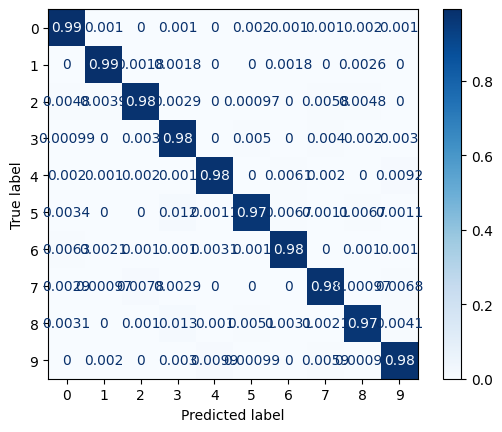

In [9]:
cm = torch.zeros(10, 10)
with torch.no_grad():
    for data, labels in test_loader:
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device)
        preds = model(data)
        for i, pred in enumerate(preds):
            cm[labels[i], pred.argmax()] += 1
cm = cm.cpu().numpy()
accuracy = cm.diagonal().sum() / cm.sum()
cm = cm / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
print(f"Accuracy: {accuracy:.4f}")

In [18]:
full_mnist = []
labels = []
for data, lbls in train_loader:
    full_mnist.append(data.view(-1, 28*28))
    labels.append(lbls)
for data, lbls in test_loader:
    full_mnist.append(data.view(-1, 28*28))
    labels.append(lbls)
full_mnist = torch.cat(full_mnist)
labels = torch.cat(labels)
full_mnist.shape, (full_mnist.numel() * full_mnist.element_size()) / 1e6

(torch.Size([70000, 784]), 219.52)

In [104]:
full_mnist.min(dim=1)

torch.return_types.min(
values=tensor([0., 0., 0.,  ..., 0., 0., 0.]),
indices=tensor([0, 0, 0,  ..., 0, 0, 0]))

In [139]:
def plot_points(points, ax, labels=labels):
    points = points.detach().cpu()
    _, _, principal_components = torch.pca_lowrank(points, q=min(10, points.shape[-1]), niter=5)
    projected_points = torch.matmul(points, principal_components[:, :2]).numpy()
    projected_points = (projected_points - projected_points.mean(axis=0, keepdims=True)) / projected_points.std(axis=0, keepdims=True)
    colors = plt.get_cmap('tab10', 10)
    for label in range(10):
        label_mask = labels == label
        ax.scatter(projected_points[label_mask, 0], projected_points[label_mask, 1], color=colors(label), s=1, alpha=0.3, label=label)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.legend()
    return ax

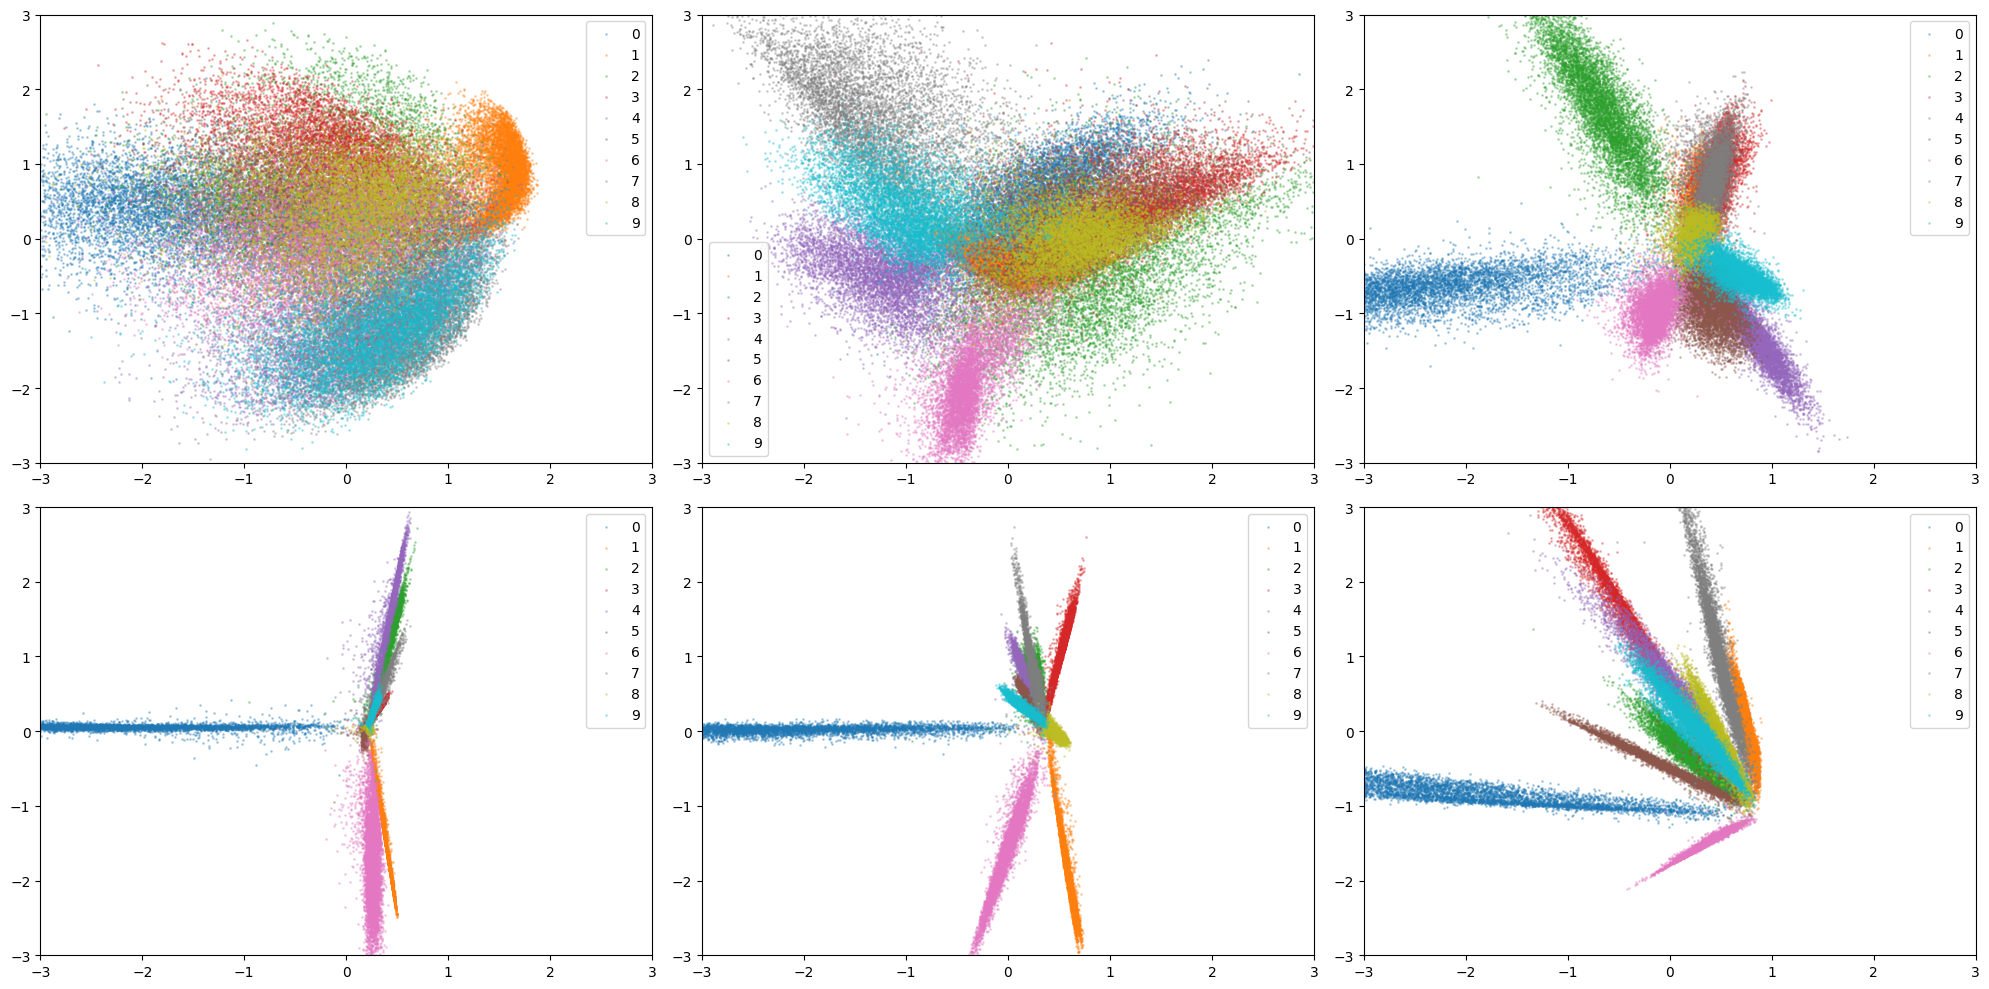

In [142]:
layers = [lambda x: x, model.dim_reduction, *[model.hidden_layers[i] for i in range(0, len(model.hidden_layers), 2)], model.output]
fig, axs = plt.subplots(2, len(layers)//2, figsize=(20, 10))
axs = axs.flatten()
pipeline_points = full_mnist.to(device)
for i, layer in enumerate(layers):
    pipeline_points = layer(pipeline_points)
    if i != 0 and i != len(layers)-1:
        pipeline_points = nn.ReLU()(pipeline_points)
    ax = plot_points(pipeline_points, axs[i])
    #ax.axis('off')
plt.tight_layout()
plt.show()

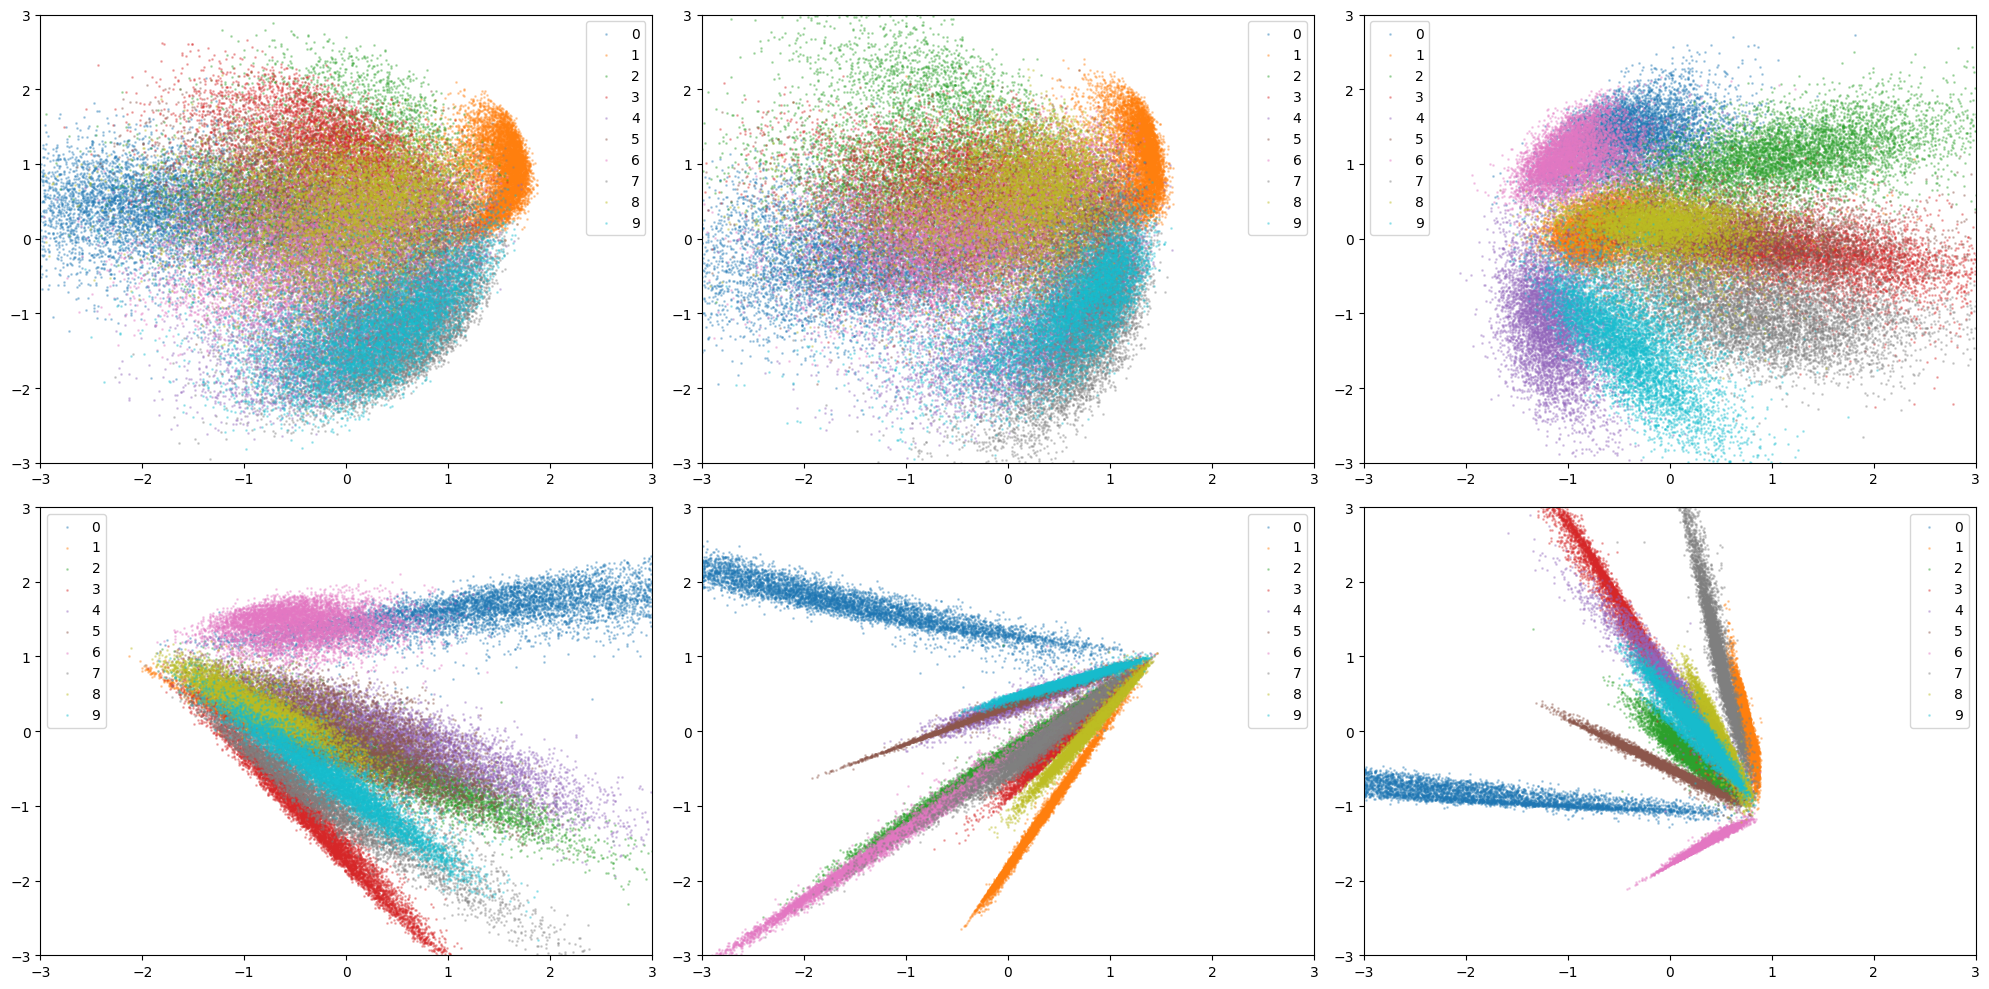

In [143]:
layers = [lambda x: x, model.dim_reduction, *[model.hidden_layers[i] for i in range(0, len(model.hidden_layers), 2)], model.output]
fig, axs = plt.subplots(2, len(layers)//2, figsize=(20, 10))
axs = axs.flatten()
pipeline_points = full_mnist.to(device)
for i, layer in enumerate(layers):
    pipeline_points = layer(pipeline_points)
    ax = plot_points(pipeline_points, axs[i])
    if i != 0 and i != len(layers)-1:
        pipeline_points = nn.ReLU()(pipeline_points)
    #ax.axis('off')
plt.tight_layout()
plt.show()

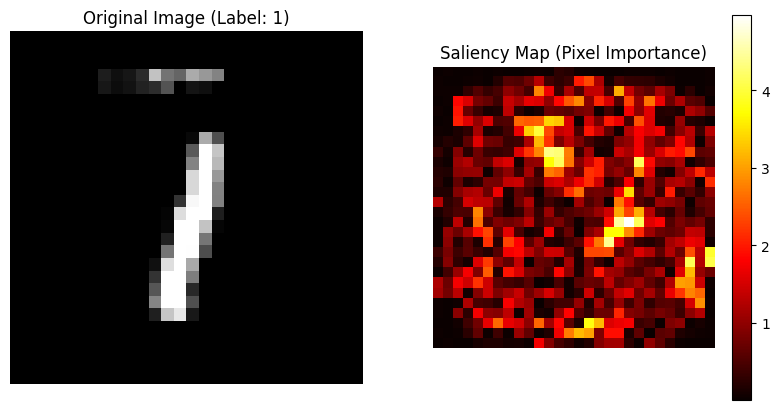

In [156]:
from captum.attr import Saliency

idx = np.random.randint(0, len(full_mnist))
# Get a single image and label from the test set
image, label = full_mnist[idx], labels[idx]

# --- Saliency Map Calculation ---
saliency = Saliency(model)
# Calculate gradients of the output with respect to the input
# The target is the correct class label for this image
grads = saliency.attribute(image.unsqueeze(0).to(device), target=label.item())

# The absolute values of the gradients indicate feature importance
# Reshape the gradients back to a 28x28 image
saliency_map = grads.detach().cpu().numpy().reshape(28, 28)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(image.numpy().reshape(28, 28), cmap='gray')
axes[0].set_title(f'Original Image (Label: {label.item()})')
axes[0].axis('off')

# Saliency Map
im = axes[1].imshow(saliency_map, cmap='hot')
axes[1].set_title('Saliency Map (Pixel Importance)')
axes[1].axis('off')
fig.colorbar(im, ax=axes[1])

plt.show()

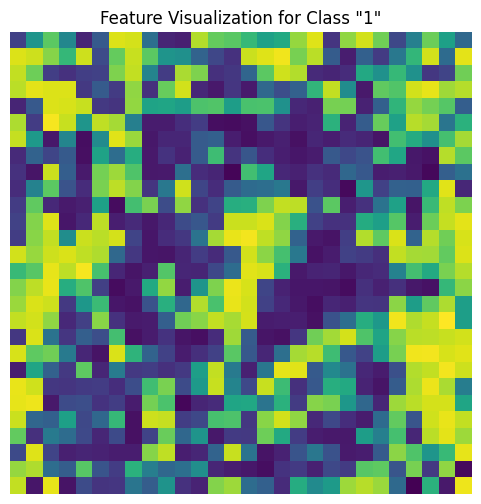

In [167]:
# --- Feature Visualization Setup ---
target_class = 1  # The digit we want to visualize
# Start with a random image (noise) and make it optimizable
# Start with a random tensor (doesn't need grad yet)
initial_noise = torch.randn(1, 28 * 28)

# Create the tensor to be optimized. This pattern ensures it's a leaf.
# .clone() makes a copy.
# .detach() severs it from any computation history.
# .requires_grad_(True) marks it as a leaf tensor we want to optimize.
dream_image = initial_noise.clone().to(device).detach().requires_grad_(True)

optimizer = (torch.optim.Adam([dream_image], lr=0.1))

# --- Optimization Loop ---
for i in range(200): # Run for 200 steps
    optimizer.zero_grad()
    # Forward pass the image through the model
    output = model(dream_image)
    # We want to MAXIMIZE the logit for our target class,
    # so we use its negative as our loss to MINIMIZE.
    loss = -output[:, target_class].mean()
    loss.backward()
    optimizer.step()

# --- Visualization ---
# Get the final optimized image
final_image = dream_image.detach().cpu().numpy().reshape(28, 28)

plt.figure(figsize=(6, 6))
plt.imshow(final_image, cmap='viridis')
plt.title(f'Feature Visualization for Class "{target_class}"')
plt.axis('off')
plt.show()